This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [42]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [43]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 3, 3, 128)         7385

**Training the convnet on MNIST images**

In [44]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.1549 - accuracy: 0.9520
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0444 - accuracy: 0.9860
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0303 - accuracy: 0.9907
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0232 - accuracy: 0.9926
Epoch 5/5
712/938 [=====================>........] - ETA: 0s - loss: 0.0177 - accuracy: 0.9949

KeyboardInterrupt: ignored

**Evaluating the convnet**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [45]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"pezhmanla","key":"46e94d6db3a453bc53a74bcb7717f876"}'}

In [46]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [47]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [48]:
!unzip -qq dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [49]:
!unzip -qq train.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [50]:
!unzip -qq test1.zip

replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


**Copying images to training, validation, and test directories**

In [88]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=3500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [89]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [90]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

**Configuring the model for training**

In [91]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [92]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 3000 files belonging to 2 classes.
Found 3000 files belonging to 2 classes.


In [93]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [94]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [95]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [96]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [97]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [98]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 13s 74ms/step - loss: 0.7201 - accuracy: 0.5358 - val_loss: 0.6771 - val_accuracy: 0.5633
Epoch 2/30
157/157 [==============================] - 11s 71ms/step - loss: 0.6539 - accuracy: 0.6250 - val_loss: 0.6221 - val_accuracy: 0.6453
Epoch 3/30
157/157 [==============================] - 12s 72ms/step - loss: 0.5816 - accuracy: 0.6976 - val_loss: 0.5930 - val_accuracy: 0.6960
Epoch 4/30
157/157 [==============================] - 12s 73ms/step - loss: 0.5295 - accuracy: 0.7374 - val_loss: 0.5353 - val_accuracy: 0.7240
Epoch 5/30
157/157 [==============================] - 11s 71ms/step - loss: 0.4951 - accuracy: 0.7682 - val_loss: 0.6009 - val_accuracy: 0.7370
Epoch 6/30
157/157 [==============================] - 12s 72ms/step - loss: 0.4368 - accuracy: 0.8052 - val_loss: 0.7259 - val_accuracy: 0.6647
Epoch 7/30
157/157 [==============================] - 11s 71ms/step - loss: 0.3907 - accuracy: 0.8300 - val_loss: 0.4109 - val_accuracy:

**Displaying curves of loss and accuracy during training**

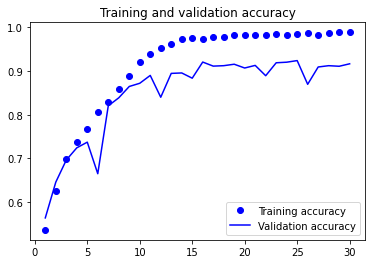

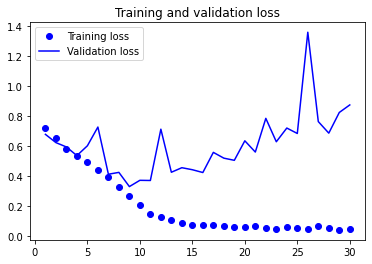

In [99]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [100]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

94/94 [==============================] - 4s 38ms/step - loss: 0.2827 - accuracy: 0.8827
Test accuracy: 0.883


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [101]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

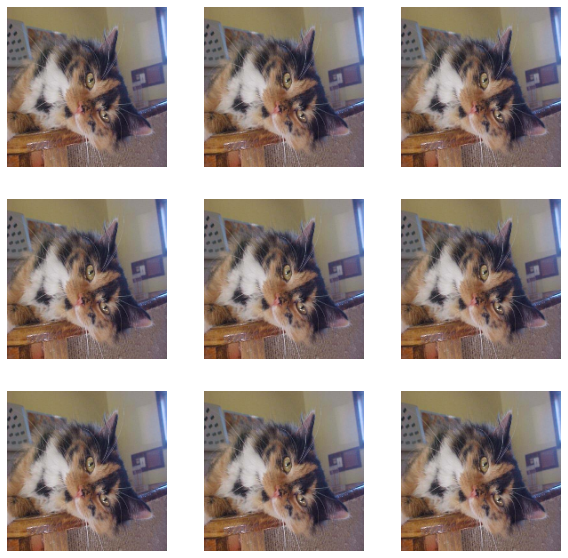

In [102]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [103]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [104]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 17s 98ms/step - loss: 0.7057 - accuracy: 0.5130 - val_loss: 0.6780 - val_accuracy: 0.5567
Epoch 2/100
157/157 [==============================] - 15s 97ms/step - loss: 0.6802 - accuracy: 0.5844 - val_loss: 0.6287 - val_accuracy: 0.6397
Epoch 3/100
157/157 [==============================] - 15s 97ms/step - loss: 0.6462 - accuracy: 0.6340 - val_loss: 0.6724 - val_accuracy: 0.6287
Epoch 4/100
157/157 [==============================] - 15s 97ms/step - loss: 0.6187 - accuracy: 0.6634 - val_loss: 0.7070 - val_accuracy: 0.5837
Epoch 5/100
157/157 [==============================] - 15s 96ms/step - loss: 0.5976 - accuracy: 0.6772 - val_loss: 0.5466 - val_accuracy: 0.7160
Epoch 6/100
157/157 [==============================] - 15s 96ms/step - loss: 0.5726 - accuracy: 0.7030 - val_loss: 0.5906 - val_accuracy: 0.6960
Epoch 7/100
157/157 [==============================] - 16s 97ms/step - loss: 0.5668 - accuracy: 0.7056 - val_loss: 0.5252 - val_ac

KeyboardInterrupt: ignored

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [105]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [106]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [107]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 24ms/step


In [108]:
train_features.shape

(5000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [109]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 2s 8ms/step - loss: 9.2974 - accuracy: 0.9460 - val_loss: 3.0736 - val_accuracy: 0.9770
Epoch 2/20
157/157 [==============================] - 1s 7ms/step - loss: 3.4923 - accuracy: 0.9794 - val_loss: 2.4410 - val_accuracy: 0.9870
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 1.8995 - accuracy: 0.9864 - val_loss: 2.1508 - val_accuracy: 0.9880
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.9763 - accuracy: 0.9936 - val_loss: 4.0471 - val_accuracy: 0.9770
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.7432 - accuracy: 0.9940 - val_loss: 2.8109 - val_accuracy: 0.9850
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.6002 - accuracy: 0.9952 - val_loss: 2.0298 - val_accuracy: 0.9927
Epoch 7/20
157/157 [==============================] - 1s 7ms/step - loss: 0.6971 - accuracy: 0.9952 - val_loss: 2.9931 - val_accuracy: 0.9893
Epoch 

**Plotting the results**

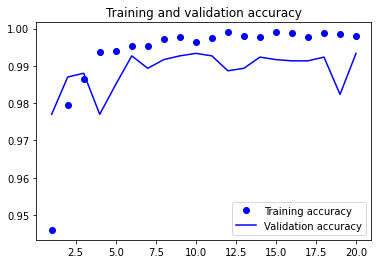

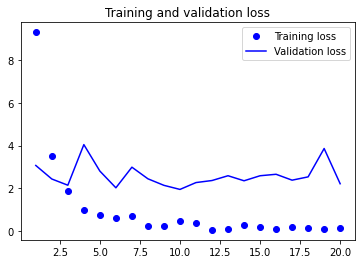

In [110]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [111]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [112]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [113]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [114]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [115]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 35s 212ms/step - loss: 11.2707 - accuracy: 0.9230 - val_loss: 3.3025 - val_accuracy: 0.9777
Epoch 2/50
157/157 [==============================] - 33s 209ms/step - loss: 6.3663 - accuracy: 0.9512 - val_loss: 3.0203 - val_accuracy: 0.9797
Epoch 3/50
157/157 [==============================] - 33s 210ms/step - loss: 4.8353 - accuracy: 0.9618 - val_loss: 2.0448 - val_accuracy: 0.9833
Epoch 4/50
157/157 [==============================] - 33s 210ms/step - loss: 3.9690 - accuracy: 0.9638 - val_loss: 1.9618 - val_accuracy: 0.9810
Epoch 5/50
157/157 [==============================] - 33s 208ms/step - loss: 3.7489 - accuracy: 0.9626 - val_loss: 3.1588 - val_accuracy: 0.9737
Epoch 6/50
157/157 [==============================] - 33s 208ms/step - loss: 2.3114 - accuracy: 0.9718 - val_loss: 1.7261 - val_accuracy: 0.9810
Epoch 7/50
157/157 [==============================] - 33s 210ms/step - loss: 1.7178 - accuracy: 0.9668 - val_loss: 1.1977 - val_a

**Evaluating the model on the test set**

In [116]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

94/94 [==============================] - 12s 116ms/step - loss: 0.2395 - accuracy: 0.9920
Test accuracy: 0.992


### Fine-tuning a pretrained model

In [117]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [118]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [119]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 37s 225ms/step - loss: 0.6725 - accuracy: 0.9812 - val_loss: 0.7080 - val_accuracy: 0.9877
Epoch 2/30
157/157 [==============================] - 36s 228ms/step - loss: 0.3971 - accuracy: 0.9850 - val_loss: 0.7062 - val_accuracy: 0.9850
Epoch 3/30
157/157 [==============================] - 36s 228ms/step - loss: 0.3134 - accuracy: 0.9868 - val_loss: 0.7466 - val_accuracy: 0.9887
Epoch 4/30
157/157 [==============================] - 36s 229ms/step - loss: 0.3450 - accuracy: 0.9866 - val_loss: 0.5685 - val_accuracy: 0.9873
Epoch 5/30
157/157 [==============================] - 36s 229ms/step - loss: 0.3354 - accuracy: 0.9862 - val_loss: 0.6251 - val_accuracy: 0.9860
Epoch 6/30
157/157 [==============================] - 36s 227ms/step - loss: 0.2762 - accuracy: 0.9886 - val_loss: 0.6959 - val_accuracy: 0.9870
Epoch 7/30
157/157 [==============================] - 36s 229ms/step - loss: 0.2173 - accuracy: 0.9892 - val_loss: 0.5452 - val_ac

KeyboardInterrupt: ignored

In [87]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 111ms/step - loss: 1.0955 - accuracy: 0.9755
Test accuracy: 0.975


## Summary